# Beijing Air Quality Forecasting Starter Notebook

## Introduction and Problem Statement

The objective of this project is to predict hourly PM2.5 concentrations in Beijing for a test period (July 2, 2013, to December 31, 2014) using historical weather and PM2.5 data from January 1, 2011, to July 2, 2013. This task is part of a Kaggle competition focused on air quality forecasting, where the goal is to minimize the Root Mean Squared Error (RMSE) between predicted and actual PM2.5 values.

PM2.5 forecasting is critical because fine particulate matter (PM2.5) poses significant health risks, including respiratory and cardiovascular diseases, particularly in urban areas like Beijing, which has historically faced severe air pollution. Accurate predictions can inform public health policies, urban planning, and pollution mitigation strategies. The dataset includes hourly measurements of PM2.5 and meteorological features like temperature, dew point, pressure, wind speed, and precipitation, which influence air quality.

## **Overall Strategy for Handling Time Series Data**
The strategy for handling the PM2.5 time-series data, spanning January 1, 2010, to December 31, 2014, with training from January 1, 2010, to July 1, 2013, and testing from July 2, 2013, to December 31, 2014, focuses on capturing temporal dependencies. It involves converting hourly data into fixed-length sequences, starting with 12 hours and increasing to 48 hours, to model daily patterns like rush-hour pollution spikes. The approach includes iterative model refinement and preprocessing adjustments to address distribution shifts between training and test sets, likely involving higher PM2.5 values or seasonal changes.

##**Justification for Using RNNs/LSTMs**
RNNs, particularly LSTMs, are selected because they maintain a memory of previous time steps, unlike feedforward networks, which is vital for predicting PM2.5 levels influenced by past hours, such as pollution accumulation or weather effects. LSTMs address the vanishing gradient problem with their forget, input, and output gates, capturing long-term patterns like seasonal trends within 48-hour sequences. Their flexibility with multivariate inputs and non-linear relationships suits the complex air quality data.

##**Plan for Data Exploration**
The data exploration plan includes calculating summary statistics—mean, median, standard deviation, min, and max PM2.5 values—to understand the range and identify outliers or trends. Visualizations like line plots of PM2.5 over time, hand time-series decomposition will detect patterns such as seasonal increases or test set shifts, guiding preprocessing and model design decisions.

##**Plan for Preprocessing**
Preprocessing involves handling missing PM2.5 values with  interpolation to ensure continuity, creating input-output sequences with a sliding window, and scaling to normalize data based on training data. Time windowing experiments with lengths e.g. 12, 24, and 48 hours will determine the optimal temporal context.

##**Plan for Experimentation**
Experimentation includes testing architectures—standard LSTM in Models, Bidirectional LSTM in Models, while varying sequence lengths, increasing LSTM units, increasing or decreasing the learning rate after choosing the initial one to start with, and adding features like BatchNormalization and Dropout to increase model performance based on training process, will be compared to assess test alignment impact.


In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate

In [ ]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
# Define the file paths for Google Drive and cloud Colab

drive_train_path = '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv'
drive_test_path = '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv'
local_train_path = '/content/train.csv'
local_test_path = '/content/test.csv'

train = None
test = None
loaded_from_drive = False

# Try loading from Google Drive first
try:
    print("Attempting to load data from Google Drive...")
    if os.path.exists(drive_train_path) and os.path.exists(drive_test_path):
        train = pd.read_csv(drive_train_path)
        test = pd.read_csv(drive_test_path)
        loaded_from_drive = True
        print("Successfully loaded data from Google Drive.")
    else:
        print("Files not found in Google Drive path. Trying local Colab environment...")

except Exception as e:
    print(f"Error loading from Google Drive: {e}. Trying local Colab environment...")

# If not loaded from Drive, try loading from cloud Colab environment
if train is None or test is None:
    try:
        print("Attempting to load data from local Colab environment...")
        if os.path.exists(local_train_path) and os.path.exists(local_test_path):
            train = pd.read_csv(local_train_path)
            test = pd.read_csv(local_test_path)
            print("Successfully loaded data from local Colab environment.")
        else:
            print("Files not found in local Colab environment.")

    except Exception as e:
        print(f"Error loading from local Colab environment: {e}")

# Check if data was loaded successfully and provide guidance
if train is None or test is None:
    print("\nERROR: Data loading failed.")
    print("Please ensure you have uploaded 'train.csv' and 'test.csv' either:")
    print(f"1. To the following path in your Google Drive: {drive_train_path} and {drive_test_path}")
    print("   (and ensure Google Drive is mounted)")
    print("OR")
    print("2. Directly upload 'train.csv' and 'test.csv' to the Colab environment using the file explorer.")
else:
    if loaded_from_drive:
        print("\nData loaded successfully from Google Drive.")
    else:
        print("\nData loaded successfully from local Colab environment.")

Attempting to load data from Google Drive...
Successfully loaded data from Google Drive.

Data loaded successfully from Google Drive.


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

## Data Description and Exploration






### Dataset Overview
The training dataset contains 30,676 hourly samples from January 1, 2011, to July 2, 2013, with 12 columns: No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
'cbwd_SE', 'cbwd_cv', 'pm2.5'. The test dataset has 13,148 samples from July 2, 2013, to December 31, 2014, with the same features except for the target 'pm2.5'. The target variable is 'pm2.5', representing the concentration of fine particulate matter (µg/m³), while other features include meteorological variables like dew point ('DEWP'), temperature ('TEMP'), pressure ('PRES'), wind directions ('cbwd'), wind speed ('Iws'), and precipitation ('Is').

In [ ]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [ ]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


In [ ]:
train.shape

(30676, 11)

In [ ]:
test.shape

(13148, 10)

In [ ]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv', 'pm2.5'],
      dtype='object')

In [ ]:
train.tail()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
datetime,,,,,,,,,,,
2013-07-01 23:00:00,30672,1.467633,0.946961,-2.088668,-0.415099,-0.069353,2.687490,-0.690542,-0.732019,-0.522096,50.0
2013-07-02 00:00:00,30673,1.329064,0.864984,-2.186052,-0.379306,-0.069353,3.393779,1.448138,-0.732019,-0.522096,41.0
2013-07-02 01:00:00,30674,1.259780,0.701029,-2.088668,-0.263130,-0.069353,4.100068,1.448138,-0.732019,-0.522096,32.0
2013-07-02 02:00:00,30675,1.190496,0.701029,-2.088668,-0.146953,-0.069353,4.806358,1.448138,-0.732019,-0.522096,19.0
2013-07-02 03:00:00,30676,1.190496,0.701029,-2.186052,-0.084366,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,18.0


In [ ]:
test.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv
datetime,,,,,,,,,,
2013-07-02 04:00:00,30677,1.190496,0.701029,-2.186052,-0.003982,-0.069353,-0.137667,1.448138,-0.732019,-0.522096
2013-07-02 05:00:00,30678,1.121211,0.619051,-2.186052,0.031811,-0.069353,-0.137667,1.448138,-0.732019,-0.522096
2013-07-02 06:00:00,30679,1.190496,0.783006,-2.186052,0.094398,-0.069353,-0.137667,1.448138,-0.732019,-0.522096
2013-07-02 07:00:00,30680,1.190496,0.946961,-2.088668,0.174782,-0.069353,-0.137667,1.448138,-0.732019,-0.522096
2013-07-02 08:00:00,30681,1.190496,1.192893,-1.991283,0.210575,-0.069353,-0.137667,1.448138,-0.732019,-0.522096


### Exploratory Data Analysis (EDA)
- **Time Series Visualization**: A plot of PM2.5 over time revealed significant variability with occasional spikes, indicating pollution events, and periods of missing data (NaNs). Red markers were used to highlight NaN locations in the PM2.5 series.
- **Smoothing**: A 120-hour moving average was applied to visualize the overall trend, showing seasonal patterns (e.g., higher PM2.5 in colder months) while retaining short-term fluctuations.
- **Missing Values**: The training set had 1921 missing PM2.5 values (out of 30,676), and other features had no missing values. The test set had no missing values.
- **Summary Statistics**: PM2.5 ranges from 0 to 994 µg/m³, with a mean of 100.79 µg/m³ and a standard deviation of 93.1 µg/m³, indicating high variability. Other features like temperature ('TEMP') range from -2.57°C to 2.34°C, and wind speed ('Iws') ranges from -0.46 to 11.23 m/s.
- **Correlation Analysis**: A correlation matrix heatmap showed high collinearity between 'DEWP', 'TEMP', and 'PRES' (e.g., correlation between 'DEWP' and 'TEMP' was 0.83). Initially, 'TEMP' and 'PRES' were considered for removal to address multicollinearity, but they were retained after experimentation showed that dropping them reduced model performance, likely because collinear features reinforced temporal patterns useful for the LSTM.

In [ ]:
train.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


In [ ]:
test.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


In [ ]:
train.describe()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


### Visualizations
- **PM2.5 Time Series Plot**: Displayed variability and NaN locations.
- **Smoothed PM2.5 Trend**: Highlighted seasonal trends using a 120-hour moving average.
- **Correlation Heatmap**: Visualized feature relationships, guiding the decision to retain collinear features.

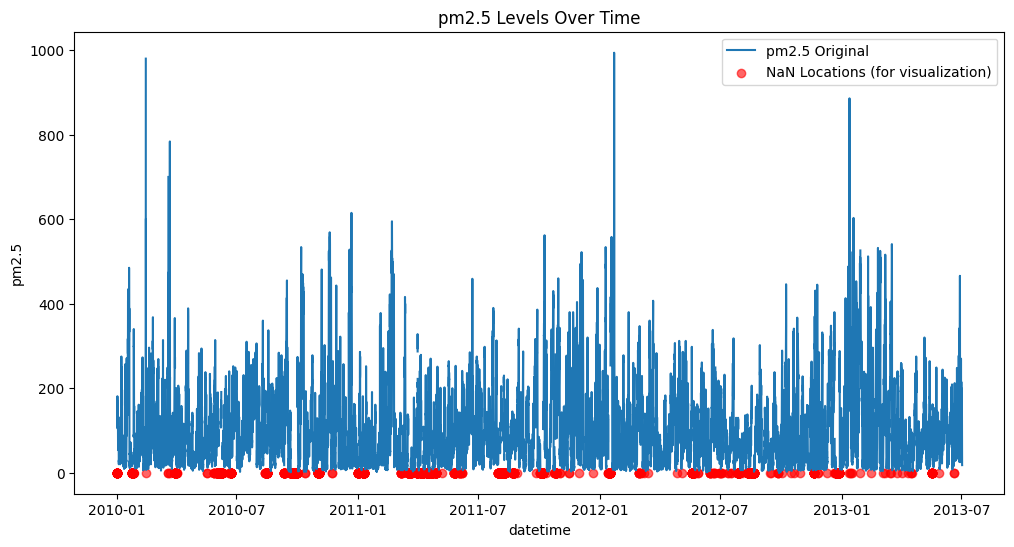

In [ ]:
# Plot the pm2.5 column to visualize the data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['pm2.5'], label='pm2.5 Original')

# Plot the points where NaNs were to see where interpolation will happen
# Keep a copy of the original data before interpolation to highlight NaNs
train_original = train.copy()
nan_indices = train_original[train_original['pm2.5'].isnull()].index
# Plot at y=0 or some offset
plt.scatter(nan_indices, [0]*len(nan_indices), color='red', label='NaN Locations (for visualization)', alpha=0.6)

plt.title('pm2.5 Levels Over Time')
plt.xlabel('datetime')
plt.ylabel('pm2.5')
plt.legend()
plt.show()

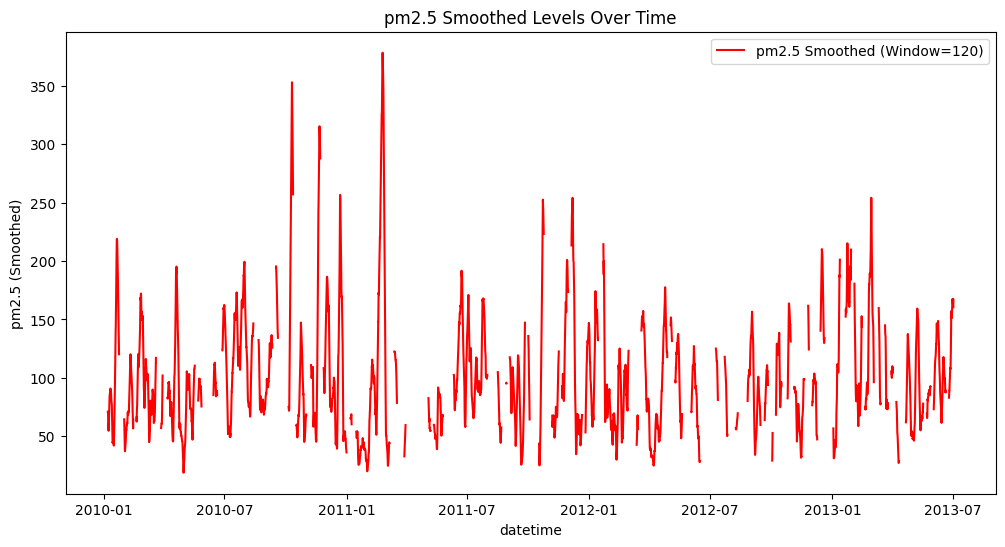

In [ ]:
# Define a window size for the moving average in hours
window_size = 120

# The original train DataFrame remains unchanged and only the smoothed trend is plotted.
# Create a new Series for the smoothed data
pm25_smoothed = train['pm2.5'].rolling(window=window_size).mean()

# Plot only the smoothed data

plt.figure(figsize=(12, 6))
plt.plot(pm25_smoothed.index, pm25_smoothed, label=f'pm2.5 Smoothed (Window={window_size})', color='red')

plt.title('pm2.5 Smoothed Levels Over Time')
plt.xlabel('datetime')
plt.ylabel('pm2.5 (Smoothed)')
plt.legend()
plt.show()

##**Preprocessing: Handling Missing Data**
The PM2.5 data shows a smoothed trend with a moving average (window=120), yet retains significant short-term variability and spikes. Cubic spline interpolation is ideal because it preserves the local structure of the data, including the sharp increases and decreases, while providing a smooth transition across NaN values. This method avoids the oversimplification of linear interpolation and the potential overfitting of polynomial methods, making it the best fit for this dataset.

In [ ]:
train.interpolate(method='cubicspline', inplace=True)
test.interpolate(method='cubicspline', inplace=True)

train.bfill(inplace=True)
test.bfill(inplace=True)

**Final check of missing values in my data**

In [ ]:
train.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


In [ ]:
test.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


In [ ]:
train.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
datetime,,,,,,,,,,,
2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,129.0
2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,129.0
2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,129.0
2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,129.0
2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,129.0


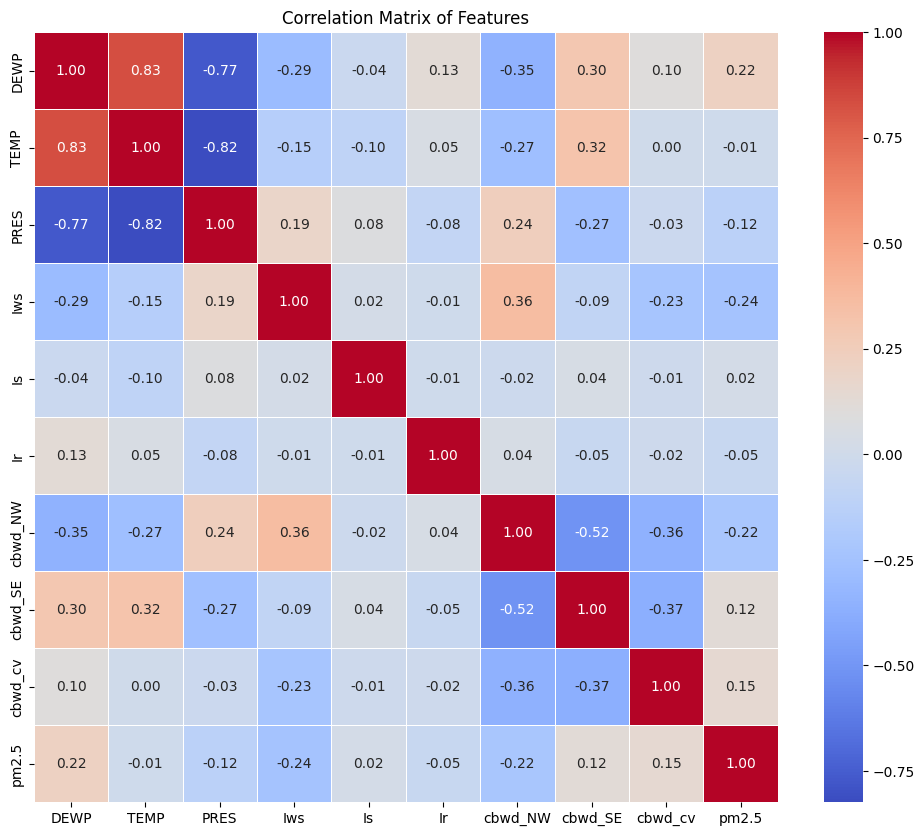

In [ ]:
columns_for_correlation = train.drop(['No'], axis=1)

# Calculate the correlation matrix
correlation_matrix = columns_for_correlation.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.show()

<!-- # Feature Selection: Addressing Multicollinearity
<!--
Based on the correlation matrix analysis, a strong positive correlation was observed between the `dewp`, `temperature`, and `pressure` features. This high correlation suggests a potential issue of multicollinearity, where these variables are linearly dependent on each other.

Physically, meteorological variables like temperature and pressure are interconnected as described by gas laws, such as the **Ideal Gas Law** ($PV = nRT$), which fundamentally relates pressure ($P$), volume ($V$), the number of moles of gas ($n$), the gas constant ($R$), and temperature ($T$). This relationship underscores why temperature and pressure often exhibit correlation in atmospheric data.

Considering that dew point (`dewp`) is a meteorological parameter fundamentally related to both temperature and atmospheric pressure in determining the saturation point of air, it can be seen as an aggregate measure reflecting the combined influence of these factors on air moisture.

To mitigate the effects of multicollinearity and simplify the model while retaining important meteorological information, the `temperature` and `pressure` columns will be dropped. The `dewp` feature will be retained as it appears to capture the essential information related to air moisture and its potential impact on `pm2.5` concentrations, while having lower correlation with other remaining features as observed in the correlation matrix. --> -->

In [ ]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv', 'pm2.5'],
      dtype='object')

In [ ]:
test.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv'],
      dtype='object')

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [ ]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
X_test = test.drop(['No'], axis=1)
y_train = train['pm2.5']

In [ ]:
X_train.columns

Index(['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv'],
      dtype='object')

In [ ]:
X_train.shape

(30676, 9)

In [ ]:
y_train.shape

(30676,)

In [ ]:
X_test.columns

Index(['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv'],
      dtype='object')

In [ ]:
X_train.tail()

,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv
datetime,,,,,,,,,
2013-07-01 23:00:00,1.467633,0.946961,-2.088668,-0.415099,-0.069353,2.687490,-0.690542,-0.732019,-0.522096
2013-07-02 00:00:00,1.329064,0.864984,-2.186052,-0.379306,-0.069353,3.393779,1.448138,-0.732019,-0.522096
2013-07-02 01:00:00,1.259780,0.701029,-2.088668,-0.263130,-0.069353,4.100068,1.448138,-0.732019,-0.522096
2013-07-02 02:00:00,1.190496,0.701029,-2.088668,-0.146953,-0.069353,4.806358,1.448138,-0.732019,-0.522096
2013-07-02 03:00:00,1.190496,0.701029,-2.186052,-0.084366,-0.069353,-0.137667,1.448138,-0.732019,-0.522096


In [ ]:
X_test.shape

(13148, 9)

In [ ]:
X_test.head()

,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv
datetime,,,,,,,,,
2013-07-02 04:00:00,1.190496,0.701029,-2.186052,-0.003982,-0.069353,-0.137667,1.448138,-0.732019,-0.522096
2013-07-02 05:00:00,1.121211,0.619051,-2.186052,0.031811,-0.069353,-0.137667,1.448138,-0.732019,-0.522096
2013-07-02 06:00:00,1.190496,0.783006,-2.186052,0.094398,-0.069353,-0.137667,1.448138,-0.732019,-0.522096
2013-07-02 07:00:00,1.190496,0.946961,-2.088668,0.174782,-0.069353,-0.137667,1.448138,-0.732019,-0.522096
2013-07-02 08:00:00,1.190496,1.192893,-1.991283,0.210575,-0.069353,-0.137667,1.448138,-0.732019,-0.522096


In [ ]:
X_test.tail()

,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv
datetime,,,,,,,,,
2014-12-31 19:00:00,-1.719447,-1.184453,1.709325,4.160780,-0.069353,-0.137667,1.448138,-0.732019,-0.522096
2014-12-31 20:00:00,-1.650162,-1.266431,1.709325,4.276956,-0.069353,-0.137667,1.448138,-0.732019,-0.522096
2014-12-31 21:00:00,-1.650162,-1.266431,1.709325,4.375337,-0.069353,-0.137667,1.448138,-0.732019,-0.522096
2014-12-31 22:00:00,-1.650162,-1.348408,1.709325,4.455720,-0.069353,-0.137667,1.448138,-0.732019,-0.522096
2014-12-31 23:00:00,-1.580878,-1.266431,1.709325,4.518308,-0.069353,-0.137667,1.448138,-0.732019,-0.522096


##**Preprocessing: Data and Build models**

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

##**Preprocessing: Time Windowing for all Models**
Time windowing experiments with sequence lengths of 12, 24, and 48 hours determine optimal context, as longer windows like 48 hours could help capture trends better than the 12-hour window, helping reduce the RMSE score.

##**Preprocessing: Scaling for all Models**
Scaling with MinMaxScaler normalizes features and targets to a 0-1 range based on training data, ensuring LSTM stability but capping predictions at 994 µg/m³, leading to underprediction on test extremes as seen when submitted to kaggle, although It helps improve convergence compared to unscaled attempts.

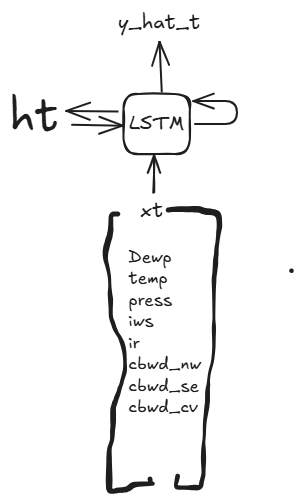

In [1]:
from IPython.display import Image, display

display(Image(filename='/content/BASIC-LSTM.png'))

##**MODEL 1**##

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def preprocess_data(X_train, y_train, X_test, seq_length=12, val_split=0.2):
    """
    Preprocess the time series data by scaling features and targets, creating sequences of length 12.
    """
    # Extract datetime index
    train_datetime = X_train.index if isinstance(X_train, pd.DataFrame) else None
    test_datetime = X_test.index if isinstance(X_test, pd.DataFrame) else None

    # Convert to NumPy arrays and drop datetime index if present
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.to_numpy()
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.to_numpy()

    # Convert y_train to NumPy array if it's a pandas Series
    if isinstance(y_train, pd.Series):
        y_train = y_train.to_numpy()

    # Check and align lengths of X_train and y_train
    if len(X_train) != len(y_train):
        print(f"Warning: Length mismatch between X_train ({len(X_train)}) and y_train ({len(y_train)}).")
        print("Trimming to match lengths to avoid errors.")
        min_len = min(len(X_train), len(y_train))
        X_train = X_train[:min_len]
        y_train = y_train[:min_len]
        if train_datetime is not None:
            train_datetime = train_datetime[:min_len]
    else:
        print(f"X_train and y_train lengths are consistent: {len(X_train)} samples.")

    # Initialize scalers
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Scale input features
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Scale target values (only for training data)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

    # Combine scaled training and test data for sequence continuity
    combined_scaled = np.vstack((X_train_scaled, X_test_scaled))
    combined_y_scaled = np.vstack((y_train_scaled, np.zeros((len(X_test_scaled), 1))))  # Placeholder for test

    # Create training sequences
    n_features = X_train_scaled.shape[1]
    train_sequences = []
    train_targets = []
    for i in range(len(X_train_scaled) - seq_length + 1):
        seq = X_train_scaled[i:i + seq_length]
        target = y_train_scaled[i + seq_length - 1]  # Target is y_12
        train_sequences.append(seq)
        train_targets.append(target)
    train_sequences = np.array(train_sequences)
    train_targets = np.array(train_targets)

    # Extend test data with the last 11 rows of training for continuity
    overlap_rows = X_train_scaled[-11:]  # Last 11 rows of training
    extended_test_scaled = np.vstack((overlap_rows, X_test_scaled))

    # Create test sequences
    test_sequences = []
    test_datetimes = []
    for i in range(len(extended_test_scaled) - seq_length + 1):
        seq = extended_test_scaled[i:i + seq_length]
        test_sequences.append(seq)
        if test_datetime is not None:
            test_datetimes.append(test_datetime[i])

    test_sequences = np.array(test_sequences)
    test_datetimes = test_datetime.tolist() if test_datetime is not None else test_datetimes[-len(X_test_scaled):]
    test_sequences = test_sequences[-len(X_test_scaled):]  # Take the last 13,148 sequences

    # Validate lengths
    if len(test_sequences) != len(test_datetimes):
        raise ValueError(f"Mismatch between test sequences ({len(test_sequences)}) and test datetimes ({len(test_datetimes)}).")
    if len(test_sequences) != len(X_test_scaled):
        raise ValueError(f"Mismatch between test sequences ({len(test_sequences)}) and X_test ({len(X_test_scaled)}).")
    print(f"Number of test sequences: {len(test_sequences)}")
    print(f"Number of test datetimes: {len(test_datetimes)}")
    print(f"First five test datetimes: {test_datetimes[:5]}")
    print(f"Last five test datetimes: {test_datetimes[-5:]}")

    # Split training sequences into train and validation
    if len(train_sequences) == 0 or len(train_targets) == 0:
        raise ValueError("Not enough training sequences.")
    if len(train_sequences) < 2:
        raise ValueError("Insufficient training sequences for validation split.")
    X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
        train_sequences, train_targets, test_size=val_split, random_state=42, shuffle=False
    )

    X_test_seq = test_sequences

    return X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y

def build_lstm_model(n_features, seq_length=12):
    """
    Build an LSTM model to predict scaled PM2.5 at the 12th timestep using h_12.
    """
    input_layer = Input(shape=(seq_length, n_features))
    lstm_out = LSTM(25, return_sequences=True, activation='tanh')(input_layer)
    lstm_out = LSTM(25, return_sequences=True, activation='tanh')(lstm_out)
    output_12th = lstm_out[:, -1, :]  # h_12 (hidden state of 12th timestep)
    final_output = Dense(1, activation='sigmoid')(output_12th)  # Predict y_12 (scaled)

    model = Model(inputs=input_layer, outputs=final_output)
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0001), loss='mse')
    return model

def calculate_rmse(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE) for evaluation or submission.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Preprocess the data
X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y = preprocess_data(
    X_train, y_train, X_test
)
# Add callback for learning rate scheduling
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
# Build and train the model
model = build_lstm_model(n_features=X_train_seq.shape[2])
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50, batch_size=32, verbose=1,
    callbacks=[lr_scheduler]
)

X_train and y_train lengths are consistent: 30676 samples.
Number of test sequences: 13148
Number of test datetimes: 13148
First five test datetimes: [Timestamp('2013-07-02 04:00:00'), Timestamp('2013-07-02 05:00:00'), Timestamp('2013-07-02 06:00:00'), Timestamp('2013-07-02 07:00:00'), Timestamp('2013-07-02 08:00:00')]
Last five test datetimes: [Timestamp('2014-12-31 19:00:00'), Timestamp('2014-12-31 20:00:00'), Timestamp('2014-12-31 21:00:00'), Timestamp('2014-12-31 22:00:00'), Timestamp('2014-12-31 23:00:00')]
Epoch 1/50


KeyboardInterrupt: 

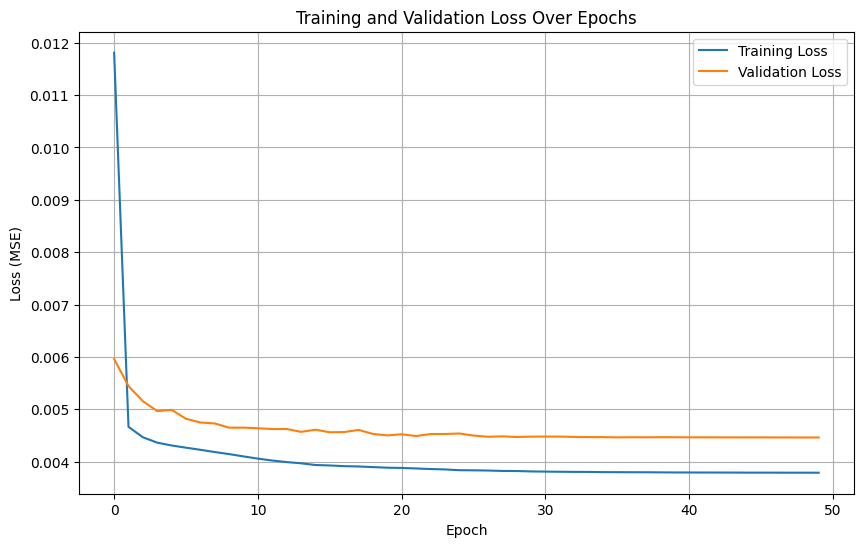

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_loss_seq12_scaled.png')
plt.show()

In [ ]:
# Inference on test set with batch prediction
y_pred_scaled = model.predict(X_test_seq, verbose=1)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Ensure predictions do not contain NaN values and are non-negative
predictions = np.nan_to_num(y_pred)
predictions = np.maximum(predictions, 0)  # Prevent negative values
predictions = np.round(predictions).astype(int)

# Validate lengths before creating submission
print(f"Number of predictions: {len(predictions)}")
print(f"Number of test datetimes: {len(test_datetimes)}")
if len(test_datetimes) != len(predictions):
    raise ValueError(f"Mismatch between test datetimes ({len(test_datetimes)}) and predictions ({len(predictions)}).")

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test_datetimes).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Debug: Print DataFrame before saving
print("Submission DataFrame before saving (first 10 rows):")
print(submission.head(10))

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_seq12_scaled.csv', index=False)
print("Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_seq12_scaled.csv'")

# Output first few predictions for verification
print("Sample predictions for submission:")
for i in range(min(5, len(predictions))):
    print(f"Sample {i+1}: Datetime = {submission['row ID'].iloc[i]}, Predicted PM2.5 = {predictions[i][0]}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Number of predictions: 13148
Number of test datetimes: 13148
Submission DataFrame before saving (first 10 rows):
                row ID  pm2.5
0   2013-07-02 4:00:00     72
1   2013-07-02 5:00:00     61
2   2013-07-02 6:00:00     46
3   2013-07-02 7:00:00     38
4   2013-07-02 8:00:00     29
5   2013-07-02 9:00:00     26
6  2013-07-02 10:00:00     26
7  2013-07-02 11:00:00     26
8  2013-07-02 12:00:00     24
9  2013-07-02 13:00:00     22
Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_seq12_scaled.csv'
Sample predictions for submission:
Sample 1: Datetime = 2013-07-02 4:00:00, Predicted PM2.5 = 72
Sample 2: Datetime = 2013-07-02 5:00:00, Predicted PM2.5 = 61
Sample 3: Datetime = 2013-07-02 6:00:00, Predicted PM2.5 = 46
Sample 4: Datetime = 2013-07-02 7:00:00, Predicted PM2.5 = 38
Sample 5: Datetime = 2013-07-02 8:00:00, Predicted PM2.5 = 29


##**MODEL 2**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def preprocess_data(X_train, y_train, X_test, seq_length=24, val_split=0.2):
    """
    Preprocess the time series data by scaling features and targets, creating sequences of variable length.
    """
    # Extract datetime index
    train_datetime = X_train.index if isinstance(X_train, pd.DataFrame) else None
    test_datetime = X_test.index if isinstance(X_test, pd.DataFrame) else None

    # Convert to NumPy arrays and drop datetime index if present
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.to_numpy()
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.to_numpy()

    # Convert y_train to NumPy array if it's a pandas Series
    if isinstance(y_train, pd.Series):
        y_train = y_train.to_numpy()

    # Check and align lengths of X_train and y_train
    if len(X_train) != len(y_train):
        print(f"Warning: Length mismatch between X_train ({len(X_train)}) and y_train ({len(y_train)}).")
        print("Trimming to match lengths to avoid errors.")
        min_len = min(len(X_train), len(y_train))
        X_train = X_train[:min_len]
        y_train = y_train[:min_len]
        if train_datetime is not None:
            train_datetime = train_datetime[:min_len]
    else:
        print(f"X_train and y_train lengths are consistent: {len(X_train)} samples.")

    # Initialize scalers
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Scale input features
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Scale target values (only for training data)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

    # Combine scaled training and test data for sequence continuity
    combined_scaled = np.vstack((X_train_scaled, X_test_scaled))
    combined_y_scaled = np.vstack((y_train_scaled, np.zeros((len(X_test_scaled), 1))))  # Placeholder for test

    # Create training sequences
    n_features = X_train_scaled.shape[1]
    train_sequences = []
    train_targets = []
    for i in range(len(X_train_scaled) - seq_length + 1):
        seq = X_train_scaled[i:i + seq_length]
        target = y_train_scaled[i + seq_length - 1]  # Target is y at the end of sequence
        train_sequences.append(seq)
        train_targets.append(target)
    train_sequences = np.array(train_sequences)
    train_targets = np.array(train_targets)

    # Extend test data with the last (seq_length - 1) rows of training for continuity
    overlap_rows = X_train_scaled[- (seq_length - 1):]  # Last (seq_length - 1) rows
    extended_test_scaled = np.vstack((overlap_rows, X_test_scaled))

    # Create test sequences
    test_sequences = []
    test_datetimes = []
    for i in range(len(extended_test_scaled) - seq_length + 1):
        seq = extended_test_scaled[i:i + seq_length]
        test_sequences.append(seq)
        if test_datetime is not None:
            test_datetimes.append(test_datetime[i])

    test_sequences = np.array(test_sequences)
    test_datetimes = test_datetime.tolist() if test_datetime is not None else test_datetimes[-len(X_test_scaled):]
    test_sequences = test_sequences[-len(X_test_scaled):]  # Take the last 13,148 sequences

    # Validate lengths
    if len(test_sequences) != len(test_datetimes):
        raise ValueError(f"Mismatch between test sequences ({len(test_sequences)}) and test datetimes ({len(test_datetimes)}).")
    if len(test_sequences) != len(X_test_scaled):
        raise ValueError(f"Mismatch between test sequences ({len(test_sequences)}) and X_test ({len(X_test_scaled)}).")
    print(f"Number of test sequences: {len(test_sequences)}")
    print(f"Number of test datetimes: {len(test_datetimes)}")
    print(f"First five test datetimes: {test_datetimes[:5]}")
    print(f"Last five test datetimes: {test_datetimes[-5:]}")

    # Split training sequences into train and validation
    if len(train_sequences) == 0 or len(train_targets) == 0:
        raise ValueError("Not enough training sequences.")
    if len(train_sequences) < 2:
        raise ValueError("Insufficient training sequences for validation split.")
    X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
        train_sequences, train_targets, test_size=val_split, random_state=42, shuffle=False
    )

    X_test_seq = test_sequences

    return X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y

def build_lstm_model(n_features, seq_length=24):
    """
    Build an LSTM model to predict scaled PM2.5 at the last timestep using its hidden state.
    """
    input_layer = Input(shape=(seq_length, n_features))
    lstm_out = LSTM(25, return_sequences=True, activation='tanh')(input_layer)
    lstm_out = LSTM(25, return_sequences=True, activation='tanh')(lstm_out)
    output_last = lstm_out[:, -1, :]  # Hidden state of the last timestep
    final_output = Dense(1, activation='sigmoid')(output_last)  # Predict scaled target

    model = Model(inputs=input_layer, outputs=final_output)
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0001), loss='mse')
    return model

def calculate_rmse(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE) for evaluation or submission.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Preprocess the data with dynamic sequence length (defaulting to 24)
X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y = preprocess_data(
    X_train, y_train, X_test, seq_length=24
)

# Add callback for learning rate scheduling
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Build and train the model
model = build_lstm_model(n_features=X_train_seq.shape[2], seq_length=24)
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50, batch_size=32, verbose=1,
    callbacks=[lr_scheduler]
)


X_train and y_train lengths are consistent: 30676 samples.
Number of test sequences: 13148
Number of test datetimes: 13148
First five test datetimes: [Timestamp('2013-07-02 04:00:00'), Timestamp('2013-07-02 05:00:00'), Timestamp('2013-07-02 06:00:00'), Timestamp('2013-07-02 07:00:00'), Timestamp('2013-07-02 08:00:00')]
Last five test datetimes: [Timestamp('2014-12-31 19:00:00'), Timestamp('2014-12-31 20:00:00'), Timestamp('2014-12-31 21:00:00'), Timestamp('2014-12-31 22:00:00'), Timestamp('2014-12-31 23:00:00')]
Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.0357 - val_loss: 0.0062 - learning_rate: 1.0000e-04
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 0.0048 - val_loss: 0.0056 - learning_rate: 1.0000e-04
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 0.0045 - val_loss: 0.0053 - learning_rate: 1.0000e-04
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.0043 - val_loss: 0.0049 - learning_rate: 1.0000e-04
Epoch 5/50
767/767

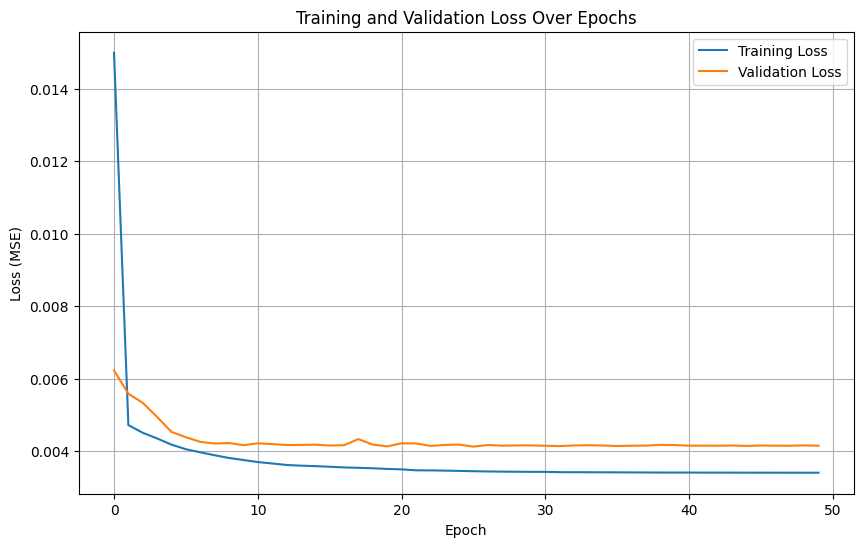

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_loss_dynamic_seq.png')
plt.show()

In [ ]:
# Inference on test set with batch prediction
y_pred_scaled = model.predict(X_test_seq, verbose=1)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Ensure predictions do not contain NaN values and are non-negative
predictions = np.nan_to_num(y_pred)
predictions = np.maximum(predictions, 0)  # Prevent negative values
predictions = np.round(predictions).astype(int)

# Validate lengths before creating submission
print(f"Number of predictions: {len(predictions)}")
print(f"Number of test datetimes: {len(test_datetimes)}")
if len(test_datetimes) != len(predictions):
    raise ValueError(f"Mismatch between test datetimes ({len(test_datetimes)}) and predictions ({len(predictions)}).")

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test_datetimes).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Debug: Print DataFrame before saving
print("Submission DataFrame before saving (first 10 rows):")
print(submission.head(10))

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_dynamic_seq.csv', index=False)
print("Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_dynamic_seq.csv'")

# Output first few predictions for verification
print("Sample predictions for submission:")
for i in range(min(5, len(predictions))):
    print(f"Sample {i+1}: Datetime = {submission['row ID'].iloc[i]}, Predicted PM2.5 = {predictions[i][0]}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
Number of predictions: 13148
Number of test datetimes: 13148
Submission DataFrame before saving (first 10 rows):
                row ID  pm2.5
0   2013-07-02 4:00:00     66
1   2013-07-02 5:00:00     57
2   2013-07-02 6:00:00     51
3   2013-07-02 7:00:00     47
4   2013-07-02 8:00:00     44
5   2013-07-02 9:00:00     42
6  2013-07-02 10:00:00     39
7  2013-07-02 11:00:00     38
8  2013-07-02 12:00:00     36
9  2013-07-02 13:00:00     36
Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_dynamic_seq.csv'
Sample predictions for submission:
Sample 1: Datetime = 2013-07-02 4:00:00, Predicted PM2.5 = 66
Sample 2: Datetime = 2013-07-02 5:00:00, Predicted PM2.5 = 57
Sample 3: Datetime = 2013-07-02 6:00:00, Predicted PM2.5 = 51
Sample 4: Datetime = 2013-07-02 7:00:00, Predicted PM2.5 = 47
Sample 5: Datetime = 2013-07-02 8:00:00, Predicted PM2.5 = 44


##**MODEL 3**##

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def preprocess_data(X_train, y_train, X_test, seq_length=48, val_split=0.2):
    """
    Preprocess the time series data by scaling features and targets, creating sequences of variable length.
    """
    # Extract datetime index
    train_datetime = X_train.index if isinstance(X_train, pd.DataFrame) else None
    test_datetime = X_test.index if isinstance(X_test, pd.DataFrame) else None

    # Convert to NumPy arrays and drop datetime index if present
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.to_numpy()
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.to_numpy()

    # Convert y_train to NumPy array if it's a pandas Series
    if isinstance(y_train, pd.Series):
        y_train = y_train.to_numpy()

    # Check and align lengths of X_train and y_train
    if len(X_train) != len(y_train):
        print(f"Warning: Length mismatch between X_train ({len(X_train)}) and y_train ({len(y_train)}).")
        print("Trimming to match lengths to avoid errors.")
        min_len = min(len(X_train), len(y_train))
        X_train = X_train[:min_len]
        y_train = y_train[:min_len]
        if train_datetime is not None:
            train_datetime = train_datetime[:min_len]
    else:
        print(f"X_train and y_train lengths are consistent: {len(X_train)} samples.")

    # Initialize scalers
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Scale input features
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Scale target values (only for training data)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

    # Combine scaled training and test data for sequence continuity
    combined_scaled = np.vstack((X_train_scaled, X_test_scaled))
    combined_y_scaled = np.vstack((y_train_scaled, np.zeros((len(X_test_scaled), 1))))  # Placeholder for test

    # Create training sequences
    n_features = X_train_scaled.shape[1]
    train_sequences = []
    train_targets = []
    for i in range(len(X_train_scaled) - seq_length + 1):
        seq = X_train_scaled[i:i + seq_length]
        target = y_train_scaled[i + seq_length - 1]  # Target is y at the end of sequence
        train_sequences.append(seq)
        train_targets.append(target)
    train_sequences = np.array(train_sequences)
    train_targets = np.array(train_targets)

    # Extend test data with the last (seq_length - 1) rows of training for continuity
    overlap_rows = X_train_scaled[- (seq_length - 1):]  # Last (seq_length - 1) rows
    extended_test_scaled = np.vstack((overlap_rows, X_test_scaled))

    # Create test sequences
    test_sequences = []
    test_datetimes = []
    for i in range(len(extended_test_scaled) - seq_length + 1):
        seq = extended_test_scaled[i:i + seq_length]
        test_sequences.append(seq)
        if test_datetime is not None:
            test_datetimes.append(test_datetime[i])

    test_sequences = np.array(test_sequences)
    test_datetimes = test_datetime.tolist() if test_datetime is not None else test_datetimes[-len(X_test_scaled):]
    test_sequences = test_sequences[-len(X_test_scaled):]  # Take the last 13,148 sequences

    # Validate lengths
    if len(test_sequences) != len(test_datetimes):
        raise ValueError(f"Mismatch between test sequences ({len(test_sequences)}) and test datetimes ({len(test_datetimes)}).")
    if len(test_sequences) != len(X_test_scaled):
        raise ValueError(f"Mismatch between test sequences ({len(test_sequences)}) and X_test ({len(X_test_scaled)}).")
    print(f"Number of test sequences: {len(test_sequences)}")
    print(f"Number of test datetimes: {len(test_datetimes)}")
    print(f"First five test datetimes: {test_datetimes[:5]}")
    print(f"Last five test datetimes: {test_datetimes[-5:]}")

    # Split training sequences into train and validation
    if len(train_sequences) == 0 or len(train_targets) == 0:
        raise ValueError("Not enough training sequences.")
    if len(train_sequences) < 2:
        raise ValueError("Insufficient training sequences for validation split.")
    X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
        train_sequences, train_targets, test_size=val_split, random_state=42, shuffle=False
    )

    X_test_seq = test_sequences

    return X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y

def build_lstm_model(n_features, seq_length=48):
    """
    Build an LSTM model to predict scaled PM2.5 at the last timestep using its hidden state.
    """
    input_layer = Input(shape=(seq_length, n_features))
    lstm_out = LSTM(50, return_sequences=True, activation='tanh')(input_layer)
    lstm_out = LSTM(50, return_sequences=True, activation='tanh')(lstm_out)
    output_last = lstm_out[:, -1, :]  # Hidden state of the last timestep
    final_output = Dense(1, activation='sigmoid')(output_last)  # Predict scaled target

    model = Model(inputs=input_layer, outputs=final_output)
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0001), loss='mse')
    return model

def calculate_rmse(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE) for evaluation or submission.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Preprocess the data with dynamic sequence length (defaulting to 48)
X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y = preprocess_data(
    X_train, y_train, X_test, seq_length=48
)

# Add callback for learning rate scheduling
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Build and train the model
model = build_lstm_model(n_features=X_train_seq.shape[2], seq_length=48)
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50, batch_size=32, verbose=1,
    callbacks=[lr_scheduler]
)


X_train and y_train lengths are consistent: 30676 samples.
Number of test sequences: 13148
Number of test datetimes: 13148
First five test datetimes: [Timestamp('2013-07-02 04:00:00'), Timestamp('2013-07-02 05:00:00'), Timestamp('2013-07-02 06:00:00'), Timestamp('2013-07-02 07:00:00'), Timestamp('2013-07-02 08:00:00')]
Last five test datetimes: [Timestamp('2014-12-31 19:00:00'), Timestamp('2014-12-31 20:00:00'), Timestamp('2014-12-31 21:00:00'), Timestamp('2014-12-31 22:00:00'), Timestamp('2014-12-31 23:00:00')]
Epoch 1/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - loss: 0.0208 - val_loss: 0.0055 - learning_rate: 1.0000e-04
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - loss: 0.0043 - val_loss: 0.0046 - learning_rate: 1.0000e-04
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - loss: 0.0039 - val_loss: 0.0044 - learning_rate: 1.0000e-04
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - loss: 0.0041 - val_loss: 0.0041 - learning_rate: 1.0000e-04
Epoch 5/50
766/766

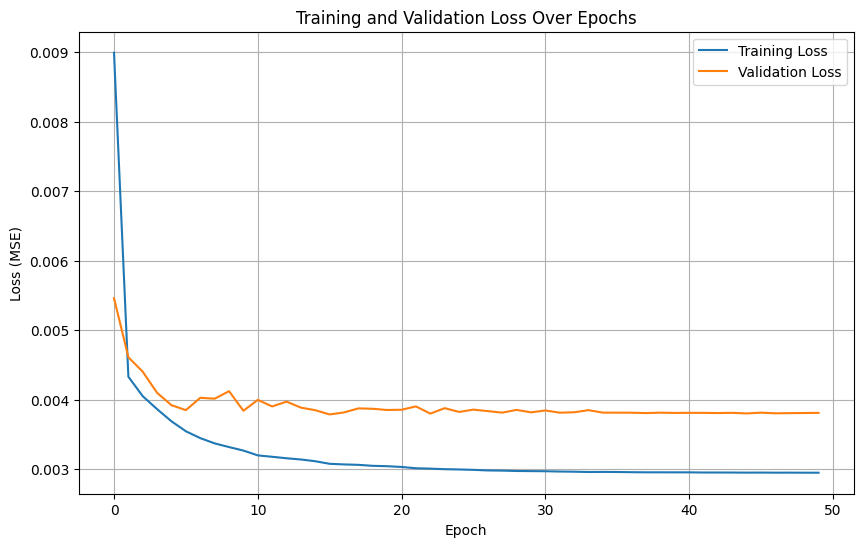

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_loss_dynamic_seq.png')
plt.show()

In [ ]:
# Inference on test set with batch prediction
y_pred_scaled = model.predict(X_test_seq, verbose=1)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Ensure predictions do not contain NaN values and are non-negative
predictions = np.nan_to_num(y_pred)
predictions = np.maximum(predictions, 0)  # Prevent negative values
predictions = np.round(predictions).astype(int)

# Validate lengths before creating submission
print(f"Number of predictions: {len(predictions)}")
print(f"Number of test datetimes: {len(test_datetimes)}")
if len(test_datetimes) != len(predictions):
    raise ValueError(f"Mismatch between test datetimes ({len(test_datetimes)}) and predictions ({len(predictions)}).")

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test_datetimes).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Debug: Print DataFrame before saving
print("Submission DataFrame before saving (first 10 rows):")
print(submission.head(10))

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_dynamic_seq.csv', index=False)
print("Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_dynamic_seq.csv'")

# Output first few predictions for verification
print("Sample predictions for submission:")
for i in range(min(5, len(predictions))):
    print(f"Sample {i+1}: Datetime = {submission['row ID'].iloc[i]}, Predicted PM2.5 = {predictions[i][0]}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
Number of predictions: 13148
Number of test datetimes: 13148
Submission DataFrame before saving (first 10 rows):
                row ID  pm2.5
0   2013-07-02 4:00:00     54
1   2013-07-02 5:00:00     45
2   2013-07-02 6:00:00     41
3   2013-07-02 7:00:00     39
4   2013-07-02 8:00:00     38
5   2013-07-02 9:00:00     39
6  2013-07-02 10:00:00     38
7  2013-07-02 11:00:00     38
8  2013-07-02 12:00:00     37
9  2013-07-02 13:00:00     35
Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_dynamic_seq.csv'
Sample predictions for submission:
Sample 1: Datetime = 2013-07-02 4:00:00, Predicted PM2.5 = 54
Sample 2: Datetime = 2013-07-02 5:00:00, Predicted PM2.5 = 45
Sample 3: Datetime = 2013-07-02 6:00:00, Predicted PM2.5 = 41
Sample 4: Datetime = 2013-07-02 7:00:00, Predicted PM2.5 = 39
Sample 5: Datetime = 2013-07-02 8:00:00, Predicted PM2.5 = 38


##**MODEL 4**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def preprocess_data(X_train, y_train, X_test, seq_length=48, val_split=0.2):
    """
    Preprocess the time series data by scaling features and targets, creating sequences of variable length.
    """
    # Extract datetime index
    train_datetime = X_train.index if isinstance(X_train, pd.DataFrame) else None
    test_datetime = X_test.index if isinstance(X_test, pd.DataFrame) else None

    # Convert to NumPy arrays and drop datetime index if present
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.to_numpy()
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.to_numpy()

    # Convert y_train to NumPy array if it's a pandas Series
    if isinstance(y_train, pd.Series):
        y_train = y_train.to_numpy()

    # Check and align lengths of X_train and y_train
    if len(X_train) != len(y_train):
        print(f"Warning: Length mismatch between X_train ({len(X_train)}) and y_train ({len(y_train)}).")
        print("Trimming to match lengths to avoid errors.")
        min_len = min(len(X_train), len(y_train))
        X_train = X_train[:min_len]
        y_train = y_train[:min_len]
        if train_datetime is not None:
            train_datetime = train_datetime[:min_len]
    else:
        print(f"X_train and y_train lengths are consistent: {len(X_train)} samples.")

    # Initialize scalers
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Scale input features
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Scale target values (only for training data)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

    # Combine scaled training and test data for sequence continuity
    combined_scaled = np.vstack((X_train_scaled, X_test_scaled))
    combined_y_scaled = np.vstack((y_train_scaled, np.zeros((len(X_test_scaled), 1))))  # Placeholder for test

    # Create training sequences
    n_features = X_train_scaled.shape[1]
    train_sequences = []
    train_targets = []
    for i in range(len(X_train_scaled) - seq_length + 1):
        seq = X_train_scaled[i:i + seq_length]
        target = y_train_scaled[i + seq_length - 1]  # Target is y at the end of sequence
        train_sequences.append(seq)
        train_targets.append(target)
    train_sequences = np.array(train_sequences)
    train_targets = np.array(train_targets)

    # Extend test data with the last (seq_length - 1) rows of training for continuity
    overlap_rows = X_train_scaled[- (seq_length - 1):]  # Last (seq_length - 1) rows
    extended_test_scaled = np.vstack((overlap_rows, X_test_scaled))

    # Create test sequences
    test_sequences = []
    test_datetimes = []
    for i in range(len(extended_test_scaled) - seq_length + 1):
        seq = extended_test_scaled[i:i + seq_length]
        test_sequences.append(seq)
        if test_datetime is not None:
            test_datetimes.append(test_datetime[i])

    test_sequences = np.array(test_sequences)
    test_datetimes = test_datetime.tolist() if test_datetime is not None else test_datetimes[-len(X_test_scaled):]
    test_sequences = test_sequences[-len(X_test_scaled):]  # Take the last 13,148 sequences

    # Validate lengths
    if len(test_sequences) != len(test_datetimes):
        raise ValueError(f"Mismatch between test sequences ({len(test_sequences)}) and test datetimes ({len(test_datetimes)}).")
    if len(test_sequences) != len(X_test_scaled):
        raise ValueError(f"Mismatch between test sequences ({len(test_sequences)}) and X_test ({len(X_test_scaled)}).")
    print(f"Number of test sequences: {len(test_sequences)}")
    print(f"Number of test datetimes: {len(test_datetimes)}")
    print(f"First five test datetimes: {test_datetimes[:5]}")
    print(f"Last five test datetimes: {test_datetimes[-5:]}")

    # Split training sequences into train and validation
    if len(train_sequences) == 0 or len(train_targets) == 0:
        raise ValueError("Not enough training sequences.")
    if len(train_sequences) < 2:
        raise ValueError("Insufficient training sequences for validation split.")
    X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
        train_sequences, train_targets, test_size=val_split, random_state=42, shuffle=False
    )

    X_test_seq = test_sequences

    return X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y

def build_lstm_model(n_features, seq_length=48):
    """
    Build an LSTM model to predict scaled PM2.5 at the last timestep using its hidden state.
    """
    input_layer = Input(shape=(seq_length, n_features))
    lstm_out = LSTM(50, return_sequences=True, activation='tanh', kernel_initializer=tf.keras.initializers.LecunNormal(seed=21))(input_layer)
    lstm_out = LSTM(50, return_sequences=True, activation='tanh')(lstm_out)
    lstm_out = tf.keras.layers.BatchNormalization()(lstm_out)
    output_last = lstm_out[:, -1, :]  # Hidden state of the last timestep
    final_output = Dense(1, activation='sigmoid')(output_last)  # Predict scaled target

    model = Model(inputs=input_layer, outputs=final_output)
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.00001), loss='mse')
    return model

def calculate_rmse(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE) for evaluation or submission.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Preprocess the data with dynamic sequence length (defaulting to 48)
X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y = preprocess_data(
    X_train, y_train, X_test, seq_length=48
)

# Add callback for learning rate scheduling
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Build and train the model
model = build_lstm_model(n_features=X_train_seq.shape[2], seq_length=48)
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50, batch_size=32, verbose=1,
    callbacks=[lr_scheduler]
)


X_train and y_train lengths are consistent: 30676 samples.
Number of test sequences: 13148
Number of test datetimes: 13148
First five test datetimes: [Timestamp('2013-07-02 04:00:00'), Timestamp('2013-07-02 05:00:00'), Timestamp('2013-07-02 06:00:00'), Timestamp('2013-07-02 07:00:00'), Timestamp('2013-07-02 08:00:00')]
Last five test datetimes: [Timestamp('2014-12-31 19:00:00'), Timestamp('2014-12-31 20:00:00'), Timestamp('2014-12-31 21:00:00'), Timestamp('2014-12-31 22:00:00'), Timestamp('2014-12-31 23:00:00')]
Epoch 1/50


KeyboardInterrupt: 

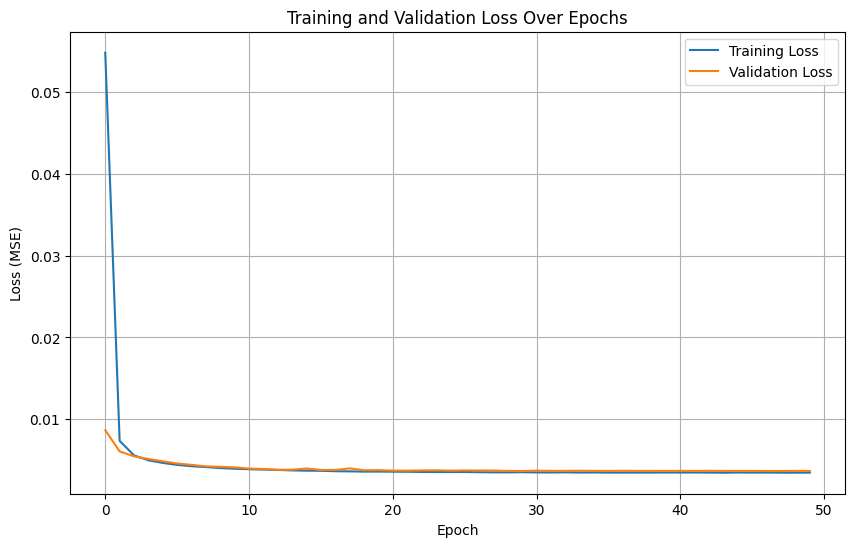

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_loss_dynamic_seq.png')
plt.show()

In [ ]:
# Inference on test set with batch prediction
y_pred_scaled = model.predict(X_test_seq, verbose=1)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Ensure predictions do not contain NaN values and are non-negative
predictions = np.nan_to_num(y_pred)
predictions = np.maximum(predictions, 0)  # Prevent negative values
predictions = np.round(predictions).astype(int)

# Validate lengths before creating submission
print(f"Number of predictions: {len(predictions)}")
print(f"Number of test datetimes: {len(test_datetimes)}")
if len(test_datetimes) != len(predictions):
    raise ValueError(f"Mismatch between test datetimes ({len(test_datetimes)}) and predictions ({len(predictions)}).")

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test_datetimes).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Debug: Print DataFrame before saving
print("Submission DataFrame before saving (first 10 rows):")
print(submission.head(10))

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_dynamic_seq.csv', index=False)
print("Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_dynamic_seq.csv'")

# Output first few predictions for verification
print("Sample predictions for submission:")
for i in range(min(5, len(predictions))):
    print(f"Sample {i+1}: Datetime = {submission['row ID'].iloc[i]}, Predicted PM2.5 = {predictions[i][0]}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step
Number of predictions: 13148
Number of test datetimes: 13148
Submission DataFrame before saving (first 10 rows):
                row ID  pm2.5
0   2013-07-02 4:00:00     63
1   2013-07-02 5:00:00     54
2   2013-07-02 6:00:00     50
3   2013-07-02 7:00:00     48
4   2013-07-02 8:00:00     48
5   2013-07-02 9:00:00     49
6  2013-07-02 10:00:00     50
7  2013-07-02 11:00:00     53
8  2013-07-02 12:00:00     54
9  2013-07-02 13:00:00     57
Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_dynamic_seq.csv'
Sample predictions for submission:
Sample 1: Datetime = 2013-07-02 4:00:00, Predicted PM2.5 = 63
Sample 2: Datetime = 2013-07-02 5:00:00, Predicted PM2.5 = 54
Sample 3: Datetime = 2013-07-02 6:00:00, Predicted PM2.5 = 50
Sample 4: Datetime = 2013-07-02 7:00:00, Predicted PM2.5 = 48
Sample 5: Datetime = 2013-07-02 8:00:00, Predicted PM2.5 = 48


##**MODEL 5**

X_train and y_train lengths are consistent: 30676 samples.
Number of test sequences: 13148
Number of test datetimes: 13148
First five test datetimes: [Timestamp('2013-07-02 04:00:00'), Timestamp('2013-07-02 05:00:00'), Timestamp('2013-07-02 06:00:00'), Timestamp('2013-07-02 07:00:00'), Timestamp('2013-07-02 08:00:00')]
Last five test datetimes: [Timestamp('2014-12-31 19:00:00'), Timestamp('2014-12-31 20:00:00'), Timestamp('2014-12-31 21:00:00'), Timestamp('2014-12-31 22:00:00'), Timestamp('2014-12-31 23:00:00')]
Epoch 1/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 91s 108ms/step - loss: 0.0069 - val_loss: 0.0050 - learning_rate: 1.0000e-05
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 135s 99ms/step - loss: 0.0043 - val_loss: 0.0044 - learning_rate: 1.0000e-05
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 82s 99ms/step - loss: 0.0040 - val_loss: 0.0044 - learning_rate: 1.0000e-05
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 74s 97ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 1.0000e-05
Epoch 5/50
766/7

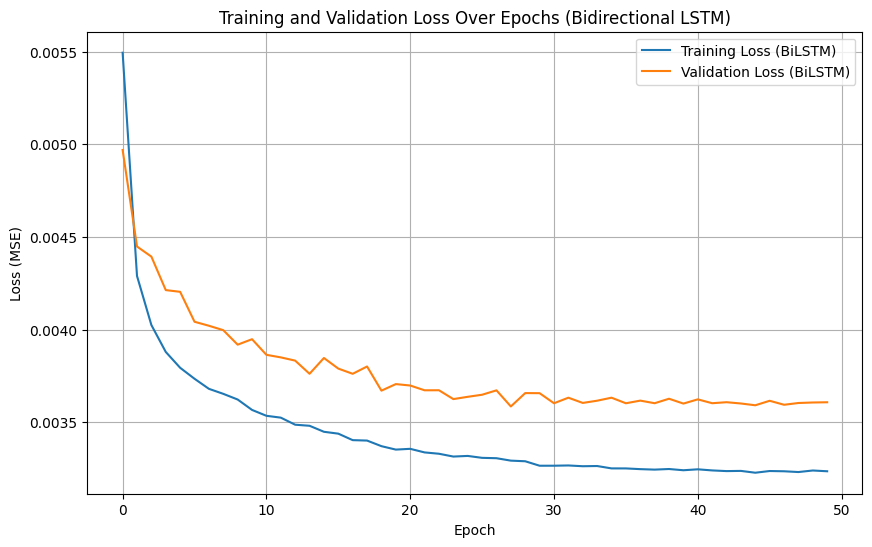

411/411 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step
Number of predictions (BiLSTM): 13148
Number of test datetimes: 13148
Submission DataFrame for BiLSTM (first 10 rows):
                row ID  pm2.5
0   2013-07-02 4:00:00     66
1   2013-07-02 5:00:00     57
2   2013-07-02 6:00:00     54
3   2013-07-02 7:00:00     50
4   2013-07-02 8:00:00     48
5   2013-07-02 9:00:00     47
6  2013-07-02 10:00:00     44
7  2013-07-02 11:00:00     45
8  2013-07-02 12:00:00     44
9  2013-07-02 13:00:00     46
Submission CSV for BiLSTM saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_bilstm.csv'
Sample predictions for BiLSTM:
Sample 1: Datetime = 2013-07-02 4:00:00, Predicted PM2.5 = 66
Sample 2: Datetime = 2013-07-02 5:00:00, Predicted PM2.5 = 57
Sample 3: Datetime = 2013-07-02 6:00:00, Predicted PM2.5 = 54
Sample 4: Datetime = 2013-07-02 7:00:00, Predicted PM2.5 = 50
Sample 5: Datetime = 2013-07-02 8:00:00, Predicted PM2.5 = 48


In [ ]:
# New Experiment: Bidirectional LSTM Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Reuse the preprocessed data from the last model (X_train_seq, y_train_seq, etc.)
# No need to re-run preprocess_data since it’s already executed
def preprocess_data(X_train, y_train, X_test, seq_length=48, val_split=0.2):
    """
    Preprocess the time series data by scaling features and targets, creating sequences of variable length.
    """
    # Extract datetime index
    train_datetime = X_train.index if isinstance(X_train, pd.DataFrame) else None
    test_datetime = X_test.index if isinstance(X_test, pd.DataFrame) else None

    # Convert to NumPy arrays and drop datetime index if present
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.to_numpy()
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.to_numpy()

    # Convert y_train to NumPy array if it's a pandas Series
    if isinstance(y_train, pd.Series):
        y_train = y_train.to_numpy()

    # Check and align lengths of X_train and y_train
    if len(X_train) != len(y_train):
        print(f"Warning: Length mismatch between X_train ({len(X_train)}) and y_train ({len(y_train)}).")
        print("Trimming to match lengths to avoid errors.")
        min_len = min(len(X_train), len(y_train))
        X_train = X_train[:min_len]
        y_train = y_train[:min_len]
        if train_datetime is not None:
            train_datetime = train_datetime[:min_len]
    else:
        print(f"X_train and y_train lengths are consistent: {len(X_train)} samples.")

    # Initialize scalers
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Scale input features
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Scale target values (only for training data)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

    # Combine scaled training and test data for sequence continuity
    combined_scaled = np.vstack((X_train_scaled, X_test_scaled))
    combined_y_scaled = np.vstack((y_train_scaled, np.zeros((len(X_test_scaled), 1))))  # Placeholder for test

    # Create training sequences
    n_features = X_train_scaled.shape[1]
    train_sequences = []
    train_targets = []
    for i in range(len(X_train_scaled) - seq_length + 1):
        seq = X_train_scaled[i:i + seq_length]
        target = y_train_scaled[i + seq_length - 1]  # Target is y at the end of sequence
        train_sequences.append(seq)
        train_targets.append(target)
    train_sequences = np.array(train_sequences)
    train_targets = np.array(train_targets)

    # Extend test data with the last (seq_length - 1) rows of training for continuity
    overlap_rows = X_train_scaled[- (seq_length - 1):]  # Last (seq_length - 1) rows
    extended_test_scaled = np.vstack((overlap_rows, X_test_scaled))

    # Create test sequences
    test_sequences = []
    test_datetimes = []
    for i in range(len(extended_test_scaled) - seq_length + 1):
        seq = extended_test_scaled[i:i + seq_length]
        test_sequences.append(seq)
        if test_datetime is not None:
            test_datetimes.append(test_datetime[i])

    test_sequences = np.array(test_sequences)
    test_datetimes = test_datetime.tolist() if test_datetime is not None else test_datetimes[-len(X_test_scaled):]
    test_sequences = test_sequences[-len(X_test_scaled):]  # Take the last 13,148 sequences

    # Validate lengths
    if len(test_sequences) != len(test_datetimes):
        raise ValueError(f"Mismatch between test sequences ({len(test_sequences)}) and test datetimes ({len(test_datetimes)}).")
    if len(test_sequences) != len(X_test_scaled):
        raise ValueError(f"Mismatch between test sequences ({len(test_sequences)}) and X_test ({len(X_test_scaled)}).")
    print(f"Number of test sequences: {len(test_sequences)}")
    print(f"Number of test datetimes: {len(test_datetimes)}")
    print(f"First five test datetimes: {test_datetimes[:5]}")
    print(f"Last five test datetimes: {test_datetimes[-5:]}")

    # Split training sequences into train and validation
    if len(train_sequences) == 0 or len(train_targets) == 0:
        raise ValueError("Not enough training sequences.")
    if len(train_sequences) < 2:
        raise ValueError("Insufficient training sequences for validation split.")
    X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
        train_sequences, train_targets, test_size=val_split, random_state=42, shuffle=False
    )

    X_test_seq = test_sequences

    return X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y

# Build Bidirectional LSTM model
def build_bilstm_model(n_features, seq_length=48):
    """
    Build a Bidirectional LSTM model to predict scaled PM2.5 at the last timestep.
    """
    input_layer = Input(shape=(seq_length, n_features))
    lstm_out = Bidirectional(LSTM(50, return_sequences=True, activation='tanh', kernel_initializer=tf.keras.initializers.LecunNormal(seed=21)))(input_layer)
    lstm_out = Bidirectional(LSTM(50, return_sequences=True, activation='tanh'))(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)
    output_last = lstm_out[:, -1, :]  # Hidden state of the last timestep
    final_output = Dense(1, activation='sigmoid')(output_last)  # Predict scaled target

    model = Model(inputs=input_layer, outputs=final_output)
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.00001), loss='mse')
    return model

# Add callback for learning rate scheduling
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Preprocess the data with dynamic sequence length (defaulting to 48)
X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y = preprocess_data(
    X_train, y_train, X_test, seq_length=48
)


# Build and train the Bidirectional LSTM model
model_bilstm = build_bilstm_model(n_features=X_train_seq.shape[2], seq_length=48)
history_bilstm = model_bilstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50, batch_size=32, verbose=1,
    callbacks=[lr_scheduler]
)

# Plot training and validation loss for BiLSTM
plt.figure(figsize=(10, 6))
plt.plot(history_bilstm.history['loss'], label='Training Loss (BiLSTM)')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss (BiLSTM)')
plt.title('Training and Validation Loss Over Epochs (Bidirectional LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_loss_bilstm.png')
plt.show()

# Inference on test set with Bidirectional LSTM
y_pred_scaled_bilstm = model_bilstm.predict(X_test_seq, verbose=1)
y_pred_bilstm = scaler_y.inverse_transform(y_pred_scaled_bilstm)
predictions_bilstm = np.nan_to_num(y_pred_bilstm)
predictions_bilstm = np.maximum(predictions_bilstm, 0)  # Prevent negative values
predictions_bilstm = np.round(predictions_bilstm).astype(int)

# Validate lengths before creating submission
print(f"Number of predictions (BiLSTM): {len(predictions_bilstm)}")
print(f"Number of test datetimes: {len(test_datetimes)}")
if len(test_datetimes) != len(predictions_bilstm):
    raise ValueError(f"Mismatch between test datetimes ({len(test_datetimes)}) and predictions (BiLSTM) ({len(predictions_bilstm)}).")

# Prepare the submission file for BiLSTM
submission_bilstm = pd.DataFrame({
    'row ID': pd.to_datetime(test_datetimes).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions_bilstm.flatten()
})

# Debug: Print DataFrame before saving
print("Submission DataFrame for BiLSTM (first 10 rows):")
print(submission_bilstm.head(10))

# Save the file in CSV format for submission on Kaggle
submission_bilstm.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_bilstm.csv', index=False)
print("Submission CSV for BiLSTM saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_bilstm.csv'")

# Output first few predictions for verification
print("Sample predictions for BiLSTM:")
for i in range(min(5, len(predictions_bilstm))):
    print(f"Sample {i+1}: Datetime = {submission_bilstm['row ID'].iloc[i]}, Predicted PM2.5 = {predictions_bilstm[i][0]}")

##**MODEL 6**

X_train and y_train lengths are consistent: 30676 samples.
Number of test sequences: 13148
Number of test datetimes: 13148
Epoch 1/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 95s 113ms/step - loss: 0.0170 - val_loss: 0.0076 - learning_rate: 1.0000e-05
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 148s 120ms/step - loss: 0.0056 - val_loss: 0.0058 - learning_rate: 1.0000e-05
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 169s 156ms/step - loss: 0.0046 - val_loss: 0.0050 - learning_rate: 1.0000e-05
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 88s 115ms/step - loss: 0.0043 - val_loss: 0.0046 - learning_rate: 1.0000e-05
Epoch 5/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 87s 113ms/step - loss: 0.0040 - val_loss: 0.0044 - learning_rate: 1.0000e-05
Epoch 6/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 145s 118ms/step - loss: 0.0039 - val_loss: 0.0043 - learning_rate: 1.0000e-05
Epoch 7/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 138s 113ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 1.0000e-05
Epoch 8/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 150s 124ms/ste

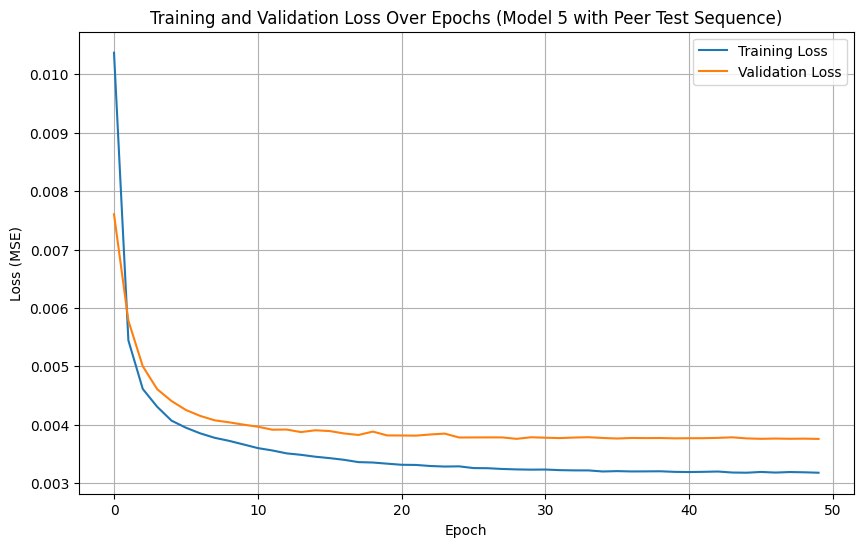

411/411 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step
Submission DataFrame for Model 5 (first 10 rows):
                row ID  pm2.5
0   2013-07-02 4:00:00     47
1   2013-07-02 5:00:00     42
2   2013-07-02 6:00:00     39
3   2013-07-02 7:00:00     38
4   2013-07-02 8:00:00     38
5   2013-07-02 9:00:00     40
6  2013-07-02 10:00:00     42
7  2013-07-02 11:00:00     44
8  2013-07-02 12:00:00     46
9  2013-07-02 13:00:00     47
Submission CSV for Model 5 saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_model5_peer_test_sequence.csv'
Sample predictions for Model 5:
Sample 1: Datetime = 2013-07-02 4:00:00, Predicted PM2.5 = 47
Sample 2: Datetime = 2013-07-02 5:00:00, Predicted PM2.5 = 42
Sample 3: Datetime = 2013-07-02 6:00:00, Predicted PM2.5 = 39
Sample 4: Datetime = 2013-07-02 7:00:00, Predicted PM2.5 = 38
Sample 5: Datetime = 2013-07-02 8:00:00, Predicted PM2.5 = 38


In [ ]:
# Experiment 6: Model 5 with Peer-Inspired Test Sequence Creation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Preprocess data function (fixed version of Model 5's preprocess_data)
def preprocess_data(X_train, y_train, X_test, seq_length=48, val_split=0.2):
    """
    Preprocess the time series data by scaling features and targets, creating sequences.
    """
    # Extract datetime index
    train_datetime = X_train.index if isinstance(X_train, pd.DataFrame) else None
    test_datetime = X_test.index if isinstance(X_test, pd.DataFrame) else None

    # Convert to NumPy arrays and drop datetime index if present
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.to_numpy()
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.to_numpy()
    if isinstance(y_train, pd.Series):
        y_train = y_train.to_numpy()

    # Check and align lengths of X_train and y_train
    if len(X_train) != len(y_train):
        print(f"Warning: Length mismatch between X_train ({len(X_train)}) and y_train ({len(y_train)}).")
        min_len = min(len(X_train), len(y_train))
        X_train = X_train[:min_len]
        y_train = y_train[:min_len]
        if train_datetime is not None:
            train_datetime = train_datetime[:min_len]
    else:
        print(f"X_train and y_train lengths are consistent: {len(X_train)} samples.")

    # Initialize scalers
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Scale input features
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Scale target values
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

    # Create training sequences
    n_features = X_train_scaled.shape[1]
    train_sequences = []
    train_targets = []
    for i in range(len(X_train_scaled) - seq_length + 1):
        seq = X_train_scaled[i:i + seq_length]
        target = y_train_scaled[i + seq_length - 1]  # Target is y at the end of sequence
        train_sequences.append(seq)
        train_targets.append(target)
    train_sequences = np.array(train_sequences)
    train_targets = np.array(train_targets)

    # Split training sequences into train and validation
    X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
        train_sequences, train_targets, test_size=val_split, random_state=42, shuffle=False
    )

    # Prepare test sequences (using your peer’s method)
    X_combined_scaled = np.vstack((X_train_scaled[-(seq_length-1):], X_test_scaled))
    n_test = len(X_test_scaled)
    X_test_seq = []
    for i in range(n_test):
        start_idx = i
        end_idx = i + seq_length
        if end_idx <= len(X_combined_scaled):  # Ensure no index out of bounds
            X_test_seq.append(X_combined_scaled[start_idx:end_idx])
    X_test_seq = np.array(X_test_seq)

    # Validate lengths
    if len(X_test_seq) != len(X_test_scaled):
        raise ValueError(f"Mismatch between test sequences ({len(X_test_seq)}) and X_test ({len(X_test_scaled)}).")
    print(f"Number of test sequences: {len(X_test_seq)}")
    print(f"Number of test datetimes: {len(test_datetime)}" if test_datetime is not None else "No test datetimes available")

    return X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetime, scaler_X, scaler_y

# Build Bidirectional LSTM model
def build_bilstm_model(n_features, seq_length=48):
    input_layer = Input(shape=(seq_length, n_features))
    lstm_out = Bidirectional(LSTM(50, return_sequences=True, activation='tanh', kernel_initializer=tf.keras.initializers.LecunNormal(seed=21)))(input_layer)
    lstm_out = Bidirectional(LSTM(50, return_sequences=True, activation='tanh'))(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)
    output_last = lstm_out[:, -1, :]
    final_output = Dense(1, activation='sigmoid')(output_last)

    model = Model(inputs=input_layer, outputs=final_output)
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.00001), loss='mse')
    return model

# Add callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Preprocess the data
X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y = preprocess_data(
    X_train, y_train, X_test, seq_length=48
)

# Build and train the Bidirectional LSTM model
model_bilstm = build_bilstm_model(n_features=X_train_seq.shape[2], seq_length=48)
history_bilstm = model_bilstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[lr_scheduler]
)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_bilstm.history['loss'], label='Training Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs (Model 5 with Peer Test Sequence)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_loss_model5_peer_test_sequence.png')
plt.show()

# Predict on test set
y_pred_scaled_bilstm = model_bilstm.predict(X_test_seq, verbose=1)
y_pred_bilstm = scaler_y.inverse_transform(y_pred_scaled_bilstm)
predictions_bilstm = np.nan_to_num(y_pred_bilstm)
predictions_bilstm = np.maximum(predictions_bilstm, 0)
predictions_bilstm = np.round(predictions_bilstm).astype(int)

# Validate lengths before creating submission
if test_datetimes is not None and len(test_datetimes) != len(predictions_bilstm):
    raise ValueError(f"Mismatch between test datetimes ({len(test_datetimes)}) and predictions ({len(predictions_bilstm)}).")
elif test_datetimes is None:
    test_datetimes = pd.date_range(start=test.index[0], periods=len(predictions_bilstm), freq='H')

# Prepare the submission file
submission_bilstm = pd.DataFrame({
    'row ID': pd.to_datetime(test_datetimes).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions_bilstm.flatten()
})

# Debug: Print DataFrame before saving
print("Submission DataFrame for Model 5 (first 10 rows):")
print(submission_bilstm.head(10))

# Save the file in CSV format for submission on Kaggle
submission_bilstm.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_model5_peer_test_sequence.csv', index=False)
print("Submission CSV for Model 5 saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_model5_peer_test_sequence.csv'")

# Output first few predictions for verification
print("Sample predictions for Model 5:")
for i in range(min(5, len(predictions_bilstm))):
    print(f"Sample {i+1}: Datetime = {submission_bilstm['row ID'].iloc[i]}, Predicted PM2.5 = {predictions_bilstm[i][0]}")

##**MODEL 7**

X_train and y_train lengths are consistent: 30676 samples.
Number of test sequences: 13148
Number of test datetimes: 13148
Epoch 1/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 98s 113ms/step - loss: 0.0857 - rmse_metric: 0.2751 - val_loss: 0.0146 - val_rmse_metric: 0.1138 - learning_rate: 1.0000e-05
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 83s 108ms/step - loss: 0.0180 - rmse_metric: 0.1315 - val_loss: 0.0088 - val_rmse_metric: 0.0870 - learning_rate: 1.0000e-05
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 145s 111ms/step - loss: 0.0133 - rmse_metric: 0.1127 - val_loss: 0.0074 - val_rmse_metric: 0.0790 - learning_rate: 1.0000e-05
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 89s 116ms/step - loss: 0.0109 - rmse_metric: 0.1026 - val_loss: 0.0066 - val_rmse_metric: 0.0731 - learning_rate: 1.0000e-05
Epoch 5/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 139s 111ms/step - loss: 0.0100 - rmse_metric: 0.0975 - val_loss: 0.0062 - val_rmse_metric: 0.0712 - learning_rate: 1.0000e-05
Epoch 6/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 90s 117ms/

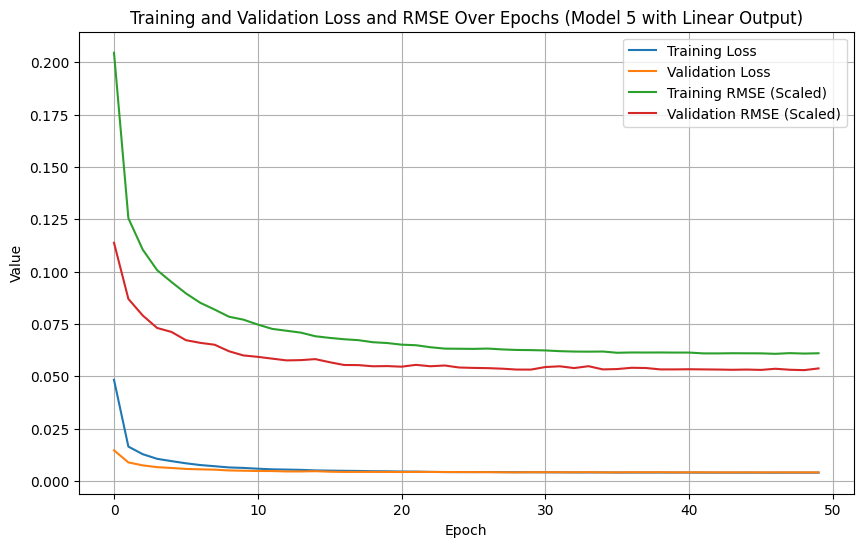

411/411 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step
Submission DataFrame for Experiment 7 (first 10 rows):
                row ID  pm2.5
0   2013-07-02 4:00:00     13
1   2013-07-02 5:00:00      5
2   2013-07-02 6:00:00      1
3   2013-07-02 7:00:00      0
4   2013-07-02 8:00:00      0
5   2013-07-02 9:00:00      2
6  2013-07-02 10:00:00      4
7  2013-07-02 11:00:00     11
8  2013-07-02 12:00:00     16
9  2013-07-02 13:00:00     26
Submission CSV for Experiment 7 saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_model5_linear_output.csv'
Sample predictions for Experiment 7:
Sample 1: Datetime = 2013-07-02 4:00:00, Predicted PM2.5 = 13
Sample 2: Datetime = 2013-07-02 5:00:00, Predicted PM2.5 = 5
Sample 3: Datetime = 2013-07-02 6:00:00, Predicted PM2.5 = 1
Sample 4: Datetime = 2013-07-02 7:00:00, Predicted PM2.5 = 0
Sample 5: Datetime = 2013-07-02 8:00:00, Predicted PM2.5 = 0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Preprocess data function (same as Experiment 6)
def preprocess_data(X_train, y_train, X_test, seq_length=48, val_split=0.2):
    train_datetime = X_train.index if isinstance(X_train, pd.DataFrame) else None
    test_datetime = X_test.index if isinstance(X_test, pd.DataFrame) else None

    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.to_numpy()
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.to_numpy()
    if isinstance(y_train, pd.Series):
        y_train = y_train.to_numpy()

    if len(X_train) != len(y_train):
        print(f"Warning: Length mismatch between X_train ({len(X_train)}) and y_train ({len(y_train)}).")
        min_len = min(len(X_train), len(y_train))
        X_train = X_train[:min_len]
        y_train = y_train[:min_len]
        if train_datetime is not None:
            train_datetime = train_datetime[:min_len]
    else:
        print(f"X_train and y_train lengths are consistent: {len(X_train)} samples.")

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

    n_features = X_train_scaled.shape[1]
    train_sequences = []
    train_targets = []
    for i in range(len(X_train_scaled) - seq_length + 1):
        seq = X_train_scaled[i:i + seq_length]
        target = y_train_scaled[i + seq_length - 1]
        train_sequences.append(seq)
        train_targets.append(target)
    train_sequences = np.array(train_sequences)
    train_targets = np.array(train_targets)

    X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
        train_sequences, train_targets, test_size=val_split, random_state=42, shuffle=False
    )

    X_combined_scaled = np.vstack((X_train_scaled[-(seq_length-1):], X_test_scaled))
    n_test = len(X_test_scaled)
    X_test_seq = []
    for i in range(n_test):
        start_idx = i
        end_idx = i + seq_length
        if end_idx <= len(X_combined_scaled):
            X_test_seq.append(X_combined_scaled[start_idx:end_idx])
    X_test_seq = np.array(X_test_seq)

    if len(X_test_seq) != len(X_test_scaled):
        raise ValueError(f"Mismatch between test sequences ({len(X_test_seq)}) and X_test ({len(X_test_scaled)}).")
    print(f"Number of test sequences: {len(X_test_seq)}")
    print(f"Number of test datetimes: {len(test_datetime)}" if test_datetime is not None else "No test datetimes available")

    return X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetime, scaler_X, scaler_y

# Build Bidirectional LSTM model with linear output
def build_bilstm_model(n_features, seq_length=48):
    input_layer = Input(shape=(seq_length, n_features))
    lstm_out = Bidirectional(LSTM(50, return_sequences=True, activation='tanh', kernel_initializer=tf.keras.initializers.LecunNormal(seed=21)))(input_layer)
    lstm_out = Bidirectional(LSTM(50, return_sequences=True, activation='tanh'))(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)
    output_last = lstm_out[:, -1, :]
    final_output = Dense(1)(output_last)  # Linear output (no activation)

    model = Model(inputs=input_layer, outputs=final_output)
    return model

# Define RMSE metric
def rmse_metric(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Preprocess the data
X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y = preprocess_data(
    X_train, y_train, X_test, seq_length=48
)

# Build and compile the model with RMSE metric
model_bilstm = build_bilstm_model(n_features=X_train_seq.shape[2], seq_length=48)
model_bilstm.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.00001),
    loss='mse',
    metrics=[rmse_metric]  # Add RMSE metric
)

# Add callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_bilstm = model_bilstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[lr_scheduler]
)

# Plot training and validation loss and RMSE
plt.figure(figsize=(10, 6))
plt.plot(history_bilstm.history['loss'], label='Training Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.plot(history_bilstm.history['rmse_metric'], label='Training RMSE (Scaled)')
plt.plot(history_bilstm.history['val_rmse_metric'], label='Validation RMSE (Scaled)')
plt.title('Training and Validation Loss and RMSE Over Epochs (Model 5 with Linear Output)')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_loss_model5_linear_output_with_rmse.png')
plt.show()

# Predict on test set
y_pred_scaled_bilstm = model_bilstm.predict(X_test_seq, verbose=1)
y_pred_bilstm = scaler_y.inverse_transform(y_pred_scaled_bilstm)
predictions_bilstm = np.nan_to_num(y_pred_bilstm)
predictions_bilstm = np.maximum(predictions_bilstm, 0)
predictions_bilstm = np.round(predictions_bilstm).astype(int)

# Prepare the submission file
submission_bilstm = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions_bilstm.flatten()
})

# Debug: Print DataFrame before saving
print("Submission DataFrame for Experiment 7 (first 10 rows):")
print(submission_bilstm.head(10))

# Save the file in CSV format for submission on Kaggle
submission_bilstm.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_model5_linear_output.csv', index=False)
print("Submission CSV for Experiment 7 saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_model5_linear_output.csv'")

# Output first few predictions for verification
print("Sample predictions for Experiment 7:")
for i in range(min(5, len(predictions_bilstm))):
    print(f"Sample {i+1}: Datetime = {submission_bilstm['row ID'].iloc[i]}, Predicted PM2.5 = {predictions_bilstm[i][0]}")